<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Retail Analytics
</h1><center/>

**Link to the article** : https://medium.com/@soulawalid/retail-analytics-project-b107cb3476bf

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from yellowbrick.cluster.elbow import kelbow_visualizer
from mpl_toolkits.mplot3d import Axes3D

<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Read the data
</h1><center/>

In [2]:
df = pd.read_excel('C:/Users/Walid/Datasets/online_retail_II.xlsx', "Year 2009-2010") #Since there is 2 tabs

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Customer Segmentation
</h1><center/>

In the segmentation matrice, I will yse a matric that is very common on customer segmenetation, espacialy in retail, called RFM
- Add definition to RFM <br>
-- R how much time pass since the customer made his last purchase <br>
-- F how much the customer purchase in a specific period of time <br>
-- M The total amount of customer purchase <br>

<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Cleaning  and Preprocessing
</h1><center/>

In [5]:
df = df.dropna(subset=['Customer ID']) # Dropping where customer is not present
df = df[(df['Quantity']>0 & (df['Price']>0))] #We just keep the data where the price and quantity are both greater than 0
df['TotalPrice'] = df['Quantity']*df['Price'] # calculate the monetary value
r = pd.to_datetime("2011-12-09") #Defining the reference for recency calculation

In [6]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


**Building RFM Matrix** <br>
- Recency : I will calculate the recency by computing the number of days between the reference date 'r' and the last purchase date
- Frequency : Counts the number of unique Invoice numbers per customer.
- Monetary : by the sum of the total price from each customer

In [7]:
rfm = df.groupby('Customer ID').agg(
    Recency = ('InvoiceDate', lambda x: (r - x.max()).days), 
    Frequency = ('Invoice','nunique'), 
    Monetary = ('TotalPrice','sum') 
).reset_index()

In [8]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,528,11,372.86
1,12347.0,366,2,1323.32
2,12348.0,437,1,222.16
3,12349.0,406,3,2671.14
4,12351.0,374,1,300.93


In [9]:
# Assigning RFM Score

I will use qcut from pandas to divide data into equal-sized bins based on quantiles. 

I will divide the data into 5 quantiles (5 bins) , each representing 20% of the data.
- 0 indicates the first bin (0–20% range).
- 1 indicates the second bin (20–40% range).
- 2 indicates the third bin (40–60% range).
- 3 indicates the fourth bin (60–80% range).
- 4 indicates the fifth bin (80–100% range).

In [10]:
rfm['R'] = pd.qcut(rfm['Recency'],5,labels=False, duplicates ='drop')+1
rfm['F'] = pd.qcut(rfm['Frequency'],5,labels=False, duplicates ='drop')+1
rfm['M'] = pd.qcut(rfm['Monetary'],5,labels=False, duplicates ='drop')+1

In [11]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R,F,M
0,12346.0,528,11,372.86,4,4,2
1,12347.0,366,2,1323.32,1,1,4
2,12348.0,437,1,222.16,4,1,1
3,12349.0,406,3,2671.14,3,2,5
4,12351.0,374,1,300.93,1,1,2


**Notes** : 
- duplicates='drop' parameter ensures that any duplicate bin edges are dropped
- "+ 1": This shifts the labels from 0-4 to 1-5.

In [12]:
# Scale the RFM Scores

In [13]:
scaler = StandardScaler()
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm[['R','F','M']]), columns = ['R','F','M'])

In [14]:
rfm_scaled.head()

,R,F,M
0,0.718902,1.675497,-0.707025
1,-1.387512,-0.860380,0.707025
2,0.718902,-0.860380,-1.414050
3,0.016764,-0.015088,1.414050
4,-1.387512,-0.860380,-0.707025


<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Building the Model
</h1><center/>

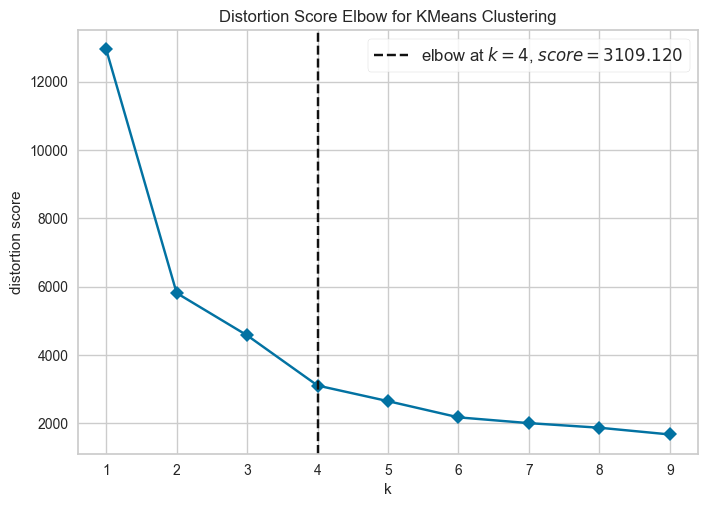

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# Determine the optimal number of clusters
model = KMeans()
kelbow_visualizer = kelbow_visualizer(model,rfm_scaled,k=(1,10), timings=False)
kelbow_visualizer.fit(rfm_scaled)
kelbow_visualizer.show()

In [16]:
# Perform clustering
kmeans = KMeans(n_clusters=4, n_init=25, random_state=123)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [17]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R,F,M,Cluster
0,12346.0,528,11,372.86,4,4,2,3
1,12347.0,366,2,1323.32,1,1,4,2
2,12348.0,437,1,222.16,4,1,1,1
3,12349.0,406,3,2671.14,3,2,5,3
4,12351.0,374,1,300.93,1,1,2,2


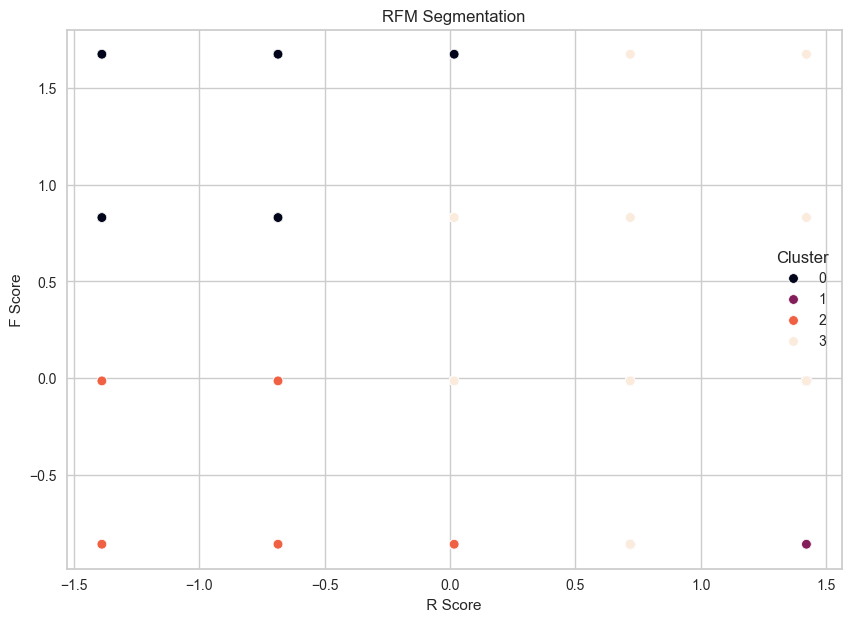

In [21]:
# Vizualisation of the cluters

plt.figure(figsize=(10,7))
sns.scatterplot(x=rfm_scaled.iloc[:,0], y=rfm_scaled.iloc[:,1], hue =rfm['Cluster'], palette="rocket")
plt.title('RFM Segmentation')
plt.xlabel(' R Score ')
plt.ylabel(' F Score ')
plt.legend(title='Cluster', loc='best')
plt.show()

<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Optional
</h1><center/>

If you want to do 3D visualisation

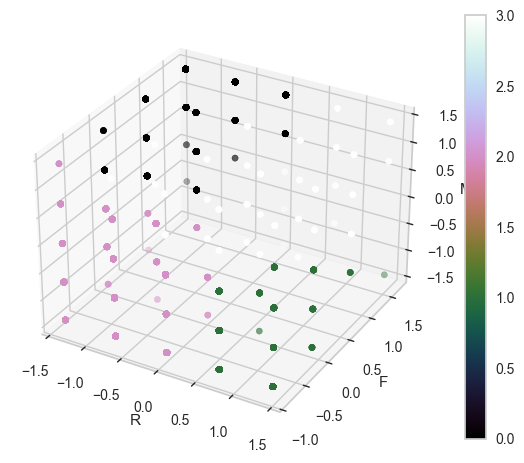

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(rfm_scaled.iloc[:, 0], rfm_scaled.iloc[:, 1], rfm_scaled.iloc[:, 2], c=rfm['Cluster'], cmap='cubehelix')

# Add labels
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')

# Add a color bar
plt.colorbar(sc)

plt.show()